In [0]:
# import io 
# from google.colab import drive
# drive.mount('drive', force_remount=True)

In [0]:
# !pip install stockstats
# !pip install ta

In [0]:
import ta
import pandas as pd
import sklearn
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm_notebook
from IPython.core.interactiveshell import InteractiveShell

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from collections import Counter

# Utils.py


In [0]:
# !pip install stockstats
# !pip install winsound (cannot since it is running on linux)

In [0]:
"""
Utility functions
"""
import re
import time
import numpy as np
import urllib.request
import shutil
import os
import pandas as pd
from PIL import Image
from ta.momentum import *
from ta.trend import *
from ta.volume import *
from ta.others import *
from ta.volatility import *
from tqdm.auto import tqdm
from stockstats import StockDataFrame as sdf
from ta import *
from matplotlib import pyplot as plt
# import winsound
import time

In [0]:
def seconds_to_minutes(seconds):
    return str(seconds // 60) + " minutes " + str(np.round(seconds % 60)) + " seconds"


def print_time(text, stime):
    seconds = (time.time() - stime)
    print(text, seconds_to_minutes(seconds))


def get_readable_ctime():
    return time.strftime("%d-%m-%Y %H_%M_%S")


def download_save(url, path_to_save, logger=None):
    if logger:
        logger.append_log("Starting download " + re.sub(r'apikey=[A-Za-z0-9]+&', 'apikey=my_api_key&', url))
    else:
        print("Starting download " + re.sub(r'apikey=[A-Za-z0-9]+&', 'apikey=my_api_key&', url))
    urllib.request.urlretrieve(url, path_to_save)
    if logger:
        logger.append_log(path_to_save + " downloaded and saved")
    else:
        print(path_to_save + " downloaded and saved")


def remove_dir(path):
    shutil.rmtree(path)
    print(path, "deleted")
    # os.rmdir(path)


def save_array_as_images(x, img_width, img_height, path, file_names):
    if os.path.exists(path):
        shutil.rmtree(path)
        print("deleted old files")

    os.makedirs(path)
    print("Image Directory created", path)
    x_temp = np.zeros((len(x), img_height, img_width))
    print("saving images...")
    stime = time.time()
    for i in tqdm(range(x.shape[0])):
        x_temp[i] = np.reshape(x[i], (img_height, img_width))
        img = Image.fromarray(x_temp[i], 'RGB')
        img.save(os.path.join(path, str(file_names[i]) + '.png'))

    print_time("Images saved at " + path, stime)
    return x_temp


def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp


def show_images(rows, columns, path):
    w = 15
    h = 15
    fig = plt.figure(figsize=(15, 15))
    files = os.listdir(path)
    for i in range(1, columns * rows + 1):
        index = np.random.randint(len(files))
        img = np.asarray(Image.open(os.path.join(path, files[index])))
        fig.add_subplot(rows, columns, i)
        plt.title(files[i], fontsize=10)
        plt.subplots_adjust(wspace=0.5, hspace=0.5)
        plt.imshow(img)
    plt.show()


def dict_to_str(d):
    return str(d).replace("{", '').replace("}", '').replace("'", "").replace(' ', '')


def cleanup_file_path(path):
    return path.replace('\\', '/').replace(" ", "_").replace(':', '_')


def white_noise_check(tags_list, logger=None, *pd_series_args):
    if len(tags_list) != len(pd_series_args):
        raise Exception("Length of tags_list and series params different. Should be same.")
    for idx, s in enumerate(pd_series_args):
        # logger.append_log("1st, 2nd element {}, {}".format(s.iloc[0], s.iloc[1]))
        m = s.mean()
        std = s.std()
        logger.append_log("mean & std for {} is {}, {}".format(tags_list[idx], m, std))


def plot(y, title, output_path, x=None):
    fig = plt.figure(figsize=(10, 10))
    # x = x if x is not None else np.arange(len(y))
    plt.title(title)
    if x is not None:
        plt.plot(x, y, 'o-')
    else:
        plt.plot(y, 'o-')
        plt.savefig(output_path)


def col1_gt_col2(col1, col2, df):
    compare_series = df[col1] > df[col2]
    print(df.iloc[compare_series[compare_series == True].index])


# def sound_alert(repeat_count=5):
#     duration = 1000  # millisecond
#     freq = 440  # Hz
#     for i in range(0, repeat_count):
#         winsound.Beep(freq, duration)
#         time.sleep(1)


def console_pretty_print_df(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(df)


############### Technical indicators ########################


# not used
def get_RSI(df, col_name, intervals):
    """
    stockstats lib seems to use 'close' column by default so col_name
    not used here.
    This calculates non-smoothed RSI
    """
    df_ss = sdf.retype(df)
    for i in intervals:
        df['rsi_' + str(i)] = df_ss['rsi_' + str(i)]

        del df['close_-1_s']
        del df['close_-1_d']
        del df['rs_' + str(i)]

        df['rsi_' + str(intervals[0])] = rsi(df['close'], i, fillna=True)
    print("RSI with stockstats done")


def get_RSI_smooth(df, col_name, intervals):
    """
    Momentum indicator
    As per https://www.investopedia.com/terms/r/rsi.asp
    RSI_1 = 100 - (100/ (1 + (avg gain% / avg loss%) ) )
    RSI_2 = 100 - (100/ (1 + (prev_avg_gain*13+avg gain% / prev_avg_loss*13 + avg loss%) ) )
    E.g. if period==6, first RSI starts from 7th index because difference of first row is NA
    http://cns.bu.edu/~gsc/CN710/fincast/Technical%20_indicators/Relative%20Strength%20Index%20(RSI).htm
    https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi
    Verified!
    """

    print("Calculating RSI")
    stime = time.time()
    prev_rsi = np.inf
    prev_avg_gain = np.inf
    prev_avg_loss = np.inf
    rolling_count = 0

    def calculate_RSI(series, period):
        # nonlocal rolling_count
        nonlocal prev_avg_gain
        nonlocal prev_avg_loss
        nonlocal rolling_count

        # num_gains = (series >= 0).sum()
        # num_losses = (series < 0).sum()
        # sum_gains = series[series >= 0].sum()
        # sum_losses = np.abs(series[series < 0].sum())
        curr_gains = series.where(series >= 0, 0)  # replace 0 where series not > 0
        curr_losses = np.abs(series.where(series < 0, 0))
        avg_gain = curr_gains.sum() / period  # * 100
        avg_loss = curr_losses.sum() / period  # * 100
        rsi = -1

        if rolling_count == 0:
            # first RSI calculation
            rsi = 100 - (100 / (1 + (avg_gain / avg_loss)))
            # print(rolling_count,"rs1=",rs, rsi)
        else:
            # smoothed RSI
            # current gain and loss should be used, not avg_gain & avg_loss
            rsi = 100 - (100 / (1 + ((prev_avg_gain * (period - 1) + curr_gains.iloc[-1]) /
                                     (prev_avg_loss * (period - 1) + curr_losses.iloc[-1]))))
            # print(rolling_count,"rs2=",rs, rsi)

        # df['rsi_'+str(period)+'_own'][period + rolling_count] = rsi
        rolling_count = rolling_count + 1
        prev_avg_gain = avg_gain
        prev_avg_loss = avg_loss
        return rsi

    diff = df[col_name].diff()[1:]  # skip na
    for period in tqdm(intervals):
        df['rsi_' + str(period)] = np.nan
        # df['rsi_'+str(period)+'_own_1'] = np.nan
        rolling_count = 0
        res = diff.rolling(period).apply(calculate_RSI, args=(period,), raw=False)
        df['rsi_' + str(period)][1:] = res

    # df.drop(['diff'], axis = 1, inplace=True)
    print_time("Calculation of RSI Done", stime)


# not used: +1, ready to use
def get_IBR(df):
    return (df['close'] - df['low']) / (df['high'] - df['low'])


def get_williamR(df, col_name, intervals):
    """
    both libs gave same result
    Momentum indicator
    """
    stime = time.time()
    print("Calculating WilliamR")
    # df_ss = sdf.retype(df)
    for i in tqdm(intervals):
        # df['wr_'+str(i)] = df_ss['wr_'+str(i)]
        df["wr_" + str(i)] = wr(df['high'], df['low'], df['close'], i, fillna=True)

    print_time("Calculation of WilliamR Done", stime)


def get_mfi(df, intervals):
    """
    momentum type indicator
    """

    stime = time.time()
    print("Calculating MFI")
    for i in tqdm(intervals):
        df['mfi_' + str(i)] = money_flow_index(df['high'], df['low'], df['close'], df['volume'], n=i, fillna=True)

    print_time("Calculation of MFI done", stime)


def get_SMA(df, col_name, intervals):
    """
    Momentum indicator
    """
    stime = time.time()
    print("Calculating SMA")
    df_ss = sdf.retype(df)
    for i in tqdm(intervals):
        df[col_name + '_sma_' + str(i)] = df_ss[col_name + '_' + str(i) + '_sma']
        del df[col_name + '_' + str(i) + '_sma']

    print_time("Calculation of SMA Done", stime)


def get_EMA(df, col_name, intervals):
    """
    Needs validation
    Momentum indicator
    """
    stime = time.time()
    print("Calculating EMA")
    df_ss = sdf.retype(df)
    for i in tqdm(intervals):
        df['ema_' + str(i)] = df_ss[col_name + '_' + str(i) + '_ema']
        del df[col_name + '_' + str(i) + '_ema']
        # df["ema_"+str(intervals[0])+'_1'] = ema_indicator(df['close'], i, fillna=True)

    print_time("Calculation of EMA Done", stime)


def get_WMA(df, col_name, intervals, hma_step=0):
    """
    Momentum indicator
    """
    stime = time.time()
    if (hma_step == 0):
        # don't show progress for internal WMA calculation for HMA
        print("Calculating WMA")

    def wavg(rolling_prices, period):
        weights = pd.Series(range(1, period + 1))
        return np.multiply(rolling_prices.values, weights.values).sum() / weights.sum()

    temp_col_count_dict = {}
    for i in tqdm(intervals, disable=(hma_step != 0)):
        res = df[col_name].rolling(i).apply(wavg, args=(i,), raw=False)
        # print("interval {} has unique values {}".format(i, res.unique()))
        if hma_step == 0:
            df['wma_' + str(i)] = res
        elif hma_step == 1:
            if 'hma_wma_' + str(i) in temp_col_count_dict.keys():
                temp_col_count_dict['hma_wma_' + str(i)] = temp_col_count_dict['hma_wma_' + str(i)] + 1
            else:
                temp_col_count_dict['hma_wma_' + str(i)] = 0
            # after halving the periods and rounding, there may be two intervals with same value e.g.
            # 2.6 & 2.8 both would lead to same value (3) after rounding. So save as diff columns
            df['hma_wma_' + str(i) + '_' + str(temp_col_count_dict['hma_wma_' + str(i)])] = 2 * res
        elif hma_step == 3:
            import re
            expr = r"^hma_[0-9]{1}"
            columns = list(df.columns)
            # print("searching", expr, "in", columns, "res=", list(filter(re.compile(expr).search, columns)))
            df['hma_' + str(len(list(filter(re.compile(expr).search, columns))))] = res

    if hma_step == 0:
        print_time("Calculation of WMA Done", stime)


def get_HMA(df, col_name, intervals):
    import re
    stime = time.time()
    print("Calculating HMA")
    expr = r"^wma_.*"

    if len(list(filter(re.compile(expr).search, list(df.columns)))) > 0:
        print("WMA calculated already. Proceed with HMA")
    else:
        print("Need WMA first...")
        get_WMA(df, col_name, intervals)

    intervals_half = np.round([i / 2 for i in intervals]).astype(int)

    # step 1 = WMA for interval/2
    # this creates cols with prefix 'hma_wma_*'
    get_WMA(df, col_name, intervals_half, 1)
    # print("step 1 done", list(df.columns))

    # step 2 = step 1 - WMA
    columns = list(df.columns)
    expr = r"^hma_wma.*"
    hma_wma_cols = list(filter(re.compile(expr).search, columns))
    rest_cols = [x for x in columns if x not in hma_wma_cols]
    expr = r"^wma.*"
    wma_cols = list(filter(re.compile(expr).search, rest_cols))

    df[hma_wma_cols] = df[hma_wma_cols].sub(df[wma_cols].values,
                                            fill_value=0)  # .rename(index=str, columns={"close": "col1", "rsi_6": "col2"})
    # df[0:10].copy().reset_index(drop=True).merge(temp.reset_index(drop=True), left_index=True, right_index=True)

    # step 3 = WMA(step 2, interval = sqrt(n))
    intervals_sqrt = np.round([np.sqrt(i) for i in intervals]).astype(int)
    for i, col in tqdm(enumerate(hma_wma_cols)):
        # print("step 3", col, intervals_sqrt[i])
        get_WMA(df, col, [intervals_sqrt[i]], 3)
    df.drop(columns=hma_wma_cols, inplace=True)
    print_time("Calculation of HMA Done", stime)


def get_TRIX(df, col_name, intervals):
    """
    TA lib actually calculates percent rate of change of a triple exponentially
    smoothed moving average not Triple EMA.
    Momentum indicator
    Need validation!
    """
    stime = time.time()
    print("Calculating TRIX")
    df_ss = sdf.retype(df)
    for i in tqdm(intervals):
        # df['trix_'+str(i)] = df_ss['trix_'+str(i)+'_sma']
        df['trix_' + str(i)] = trix(df['close'], i, fillna=True)

    # df.drop(columns=['trix','trix_6_sma',])
    print_time("Calculation of TRIX Done", stime)


def get_DMI(df, col_name, intervals):
    """
    trend indicator
    TA gave same/wrong result
    """
    stime = time.time()
    print("Calculating DMI")
    df_ss = sdf.retype(df)
    for i in tqdm(intervals):
        # df['dmi_'+str(i)] = adx(df['high'], df['low'], df['close'], n=i, fillna=True)
        df['dmi_' + str(i)] = df_ss['adx_' + str(i) + '_ema']

    drop_columns = ['high_delta', 'um', 'low_delta', 'dm', 'pdm', 'pdm_14_ema', 'pdm_14',
                    'close_-1_s', 'tr', 'tr_14_smma', 'atr_14']
    # drop_columns = ['high_delta', 'um', 'low_delta', 'dm', 'pdm', 'pdm_14_ema',
    #                 'pdm_14', 'close_-1_s', 'tr', 'atr_14', 'pdi_14', 'pdi',
    #                 'mdm', 'mdm_14_ema', 'mdm_14', 'mdi_14', 'mdi', 'dx_14',
    #                 'dx', 'adx', 'adxr']
    expr1 = r'dx_\d+_ema'
    expr2 = r'adx_\d+_ema'
    import re
    drop_columns.extend(list(filter(re.compile(expr1).search, list(df.columns)[9:])))
    drop_columns.extend(list(filter(re.compile(expr2).search, list(df.columns)[9:])))
    df.drop(columns=drop_columns, inplace=True)
    print_time("Calculation of DMI done", stime)


def get_CCI(df, col_name, intervals):
    stime = time.time()
    print("Calculating CCI")
    df_ss = sdf.retype(df)
    for i in tqdm(intervals):
        # df['cci_'+str(i)] = df_ss['cci_'+str(i)]
        df['cci_' + str(i)] = cci(df['high'], df['low'], df['close'], i, fillna=True)

    print_time("Calculation of CCI Done", stime)


def get_BB_MAV(df, col_name, intervals):
    """
    volitility indicator
    """

    stime = time.time()
    print("Calculating Bollinger Band MAV")
    df_ss = sdf.retype(df)
    for i in tqdm(intervals):
        df['bb_' + str(i)] = bollinger_mavg(df['close'], n=i, fillna=True)

    print_time("Calculation of Bollinger Band MAV done", stime)


def get_CMO(df, col_name, intervals):
    """
    Chande Momentum Oscillator
    As per https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/cmo
    CMO = 100 * ((Sum(ups) - Sum(downs))/ ( (Sum(ups) + Sum(downs) ) )
    range = +100 to -100
    params: df -> dataframe with financial instrument history
            col_name -> column name for which CMO is to be calculated
            intervals -> list of periods for which to calculated
    return: None (adds the result in a column)
    """

    print("Calculating CMO")
    stime = time.time()

    def calculate_CMO(series, period):
        # num_gains = (series >= 0).sum()
        # num_losses = (series < 0).sum()
        sum_gains = series[series >= 0].sum()
        sum_losses = np.abs(series[series < 0].sum())
        cmo = 100 * ((sum_gains - sum_losses) / (sum_gains + sum_losses))
        return np.round(cmo, 3)

    diff = df[col_name].diff()[1:]  # skip na
    for period in tqdm(intervals):
        df['cmo_' + str(period)] = np.nan
        res = diff.rolling(period).apply(calculate_CMO, args=(period,), raw=False)
        df['cmo_' + str(period)][1:] = res

    print_time("Calculation of CMO Done", stime)


# not used. on close(12,16): +3, ready to use
def get_MACD(df):
    """
    Not used
    Same for both
    calculated for same 12 and 26 periods on close only!! Not different periods.
    creates colums macd, macds, macdh
    """
    stime = time.time()
    print("Calculating MACD")
    df_ss = sdf.retype(df)
    df['macd'] = df_ss['macd']
    # df['macd_'+str(i)] = macd(df['close'], fillna=True)

    del df['macd_']
    del df['close_12_ema']
    del df['close_26_ema']
    print_time("Calculation of MACD done", stime)


# not implemented. period 12,26: +1, ready to use
def get_PPO(df, col_name, intervals):
    """
    As per https://www.investopedia.com/terms/p/ppo.asp
    uses EMA(12) and EMA(26) to calculate PPO value
    params: df -> dataframe with financial instrument history
            col_name -> column name for which CMO is to be calculated
            intervals -> list of periods for which to calculated
    return: None (adds the result in a column)
    calculated for same 12 and 26 periods only!!
    """
    stime = time.time()
    print("Calculating PPO")
    df_ss = sdf.retype(df)
    df['ema_' + str(12)] = df_ss[col_name + '_' + str(12) + '_ema']
    del df['close_' + str(12) + '_ema']
    df['ema_' + str(26)] = df_ss[col_name + '_' + str(26) + '_ema']
    del df['close_' + str(26) + '_ema']
    df['ppo'] = ((df['ema_12'] - df['ema_26']) / df['ema_26']) * 100

    del df['ema_12']
    del df['ema_26']

    print_time("Calculation of PPO Done", stime)


def get_ROC(df, col_name, intervals):
    """
    Momentum oscillator
    As per implement https://www.investopedia.com/terms/p/pricerateofchange.asp
    https://school.stockcharts.com/doku.php?id=technical_indicators:rate_of_change_roc_and_momentum
    ROC = (close_price_n - close_price_(n-1) )/close_price_(n-1) * 100
    params: df -> dataframe with financial instrument history
            col_name -> column name for which CMO is to be calculated
            intervals -> list of periods for which to calculated
    return: None (adds the result in a column)
    """
    stime = time.time()
    print("Calculating ROC")

    def calculate_roc(series, period):
        return ((series.iloc[-1] - series.iloc[0]) / series.iloc[0]) * 100

    for period in intervals:
        df['roc_' + str(period)] = np.nan
        # for 12 day period, 13th day price - 1st day price
        res = df['close'].rolling(period + 1).apply(calculate_roc, args=(period,), raw=False)
        # print(len(df), len(df[period:]), len(res))
        df['roc_' + str(period)] = res

    print_time("Calculation of ROC done", stime)


# not implemented, can't find
def get_PSI(df, col_name, intervals):
    """
    TODO implement
    """
    pass


def get_DPO(df, col_name, intervals):
    """
    Trend Oscillator type indicator
    """

    stime = time.time()
    print("Calculating DPO")
    for i in tqdm(intervals):
        df['dpo_' + str(i)] = dpo(df['close'], n=i)

    print_time("Calculation of DPO done", stime)


def get_kst(df, col_name, intervals):
    """
    Trend Oscillator type indicator
    """

    stime = time.time()
    print("Calculating KST")
    for i in tqdm(intervals):
        df['kst_' + str(i)] = kst(df['close'], i)

    print_time("Calculation of KST done", stime)


def get_CMF(df, col_name, intervals):
    """
    An oscillator type indicator & volume type
    No other implementation found
    """
    stime = time.time()
    print("Calculating CMF")
    for i in tqdm(intervals):
        df['cmf_' + str(i)] = chaikin_money_flow(df['high'], df['low'], df['close'], df['volume'], i, fillna=True)

    print_time("Calculation of CMF done", stime)


def get_force_index(df, intervals):
    stime = time.time()
    print("Calculating Force Index")
    for i in tqdm(intervals):
        df['fi_' + str(i)] = force_index(df['close'], df['volume'], 5, fillna=True)

    print_time("Calculation of Force Index done", stime)


def get_EOM(df, col_name, intervals):
    """
    An Oscillator type indicator and volume type
    Ease of Movement : https://www.investopedia.com/terms/e/easeofmovement.asp
    """
    stime = time.time()
    print("Calculating EOM")
    for i in tqdm(intervals):
        df['eom_' + str(i)] = ease_of_movement(df['high'], df['low'], df['volume'], n=i, fillna=True)

    print_time("Calculation of EOM done", stime)


# not used. +1
def get_volume_delta(df):
    stime = time.time()
    print("Calculating volume delta")
    df_ss = sdf.retype(df)
    df_ss['volume_delta']

    print_time("Calculation of Volume Delta done", stime)


# not used. +2 for each interval kdjk and rsv
def get_kdjk_rsv(df, intervals):
    stime = time.time()
    print("Calculating KDJK, RSV")
    df_ss = sdf.retype(df)
    for i in tqdm(intervals):
        df['kdjk_' + str(i)] = df_ss['kdjk_' + str(i)]

    print_time("Calculation of EMA Done", stime)

# Logger.py

In [0]:
from collections import deque
import threading
import os
import time


In [0]:
class Logger:

	LOG_QUEUE_SIZE = 50

	def __init__(self, log_file_path="/content/drive/My Drive/Colab Notebooks/inputs/", log_file_name_prefix="nasdaq", log_queue_size=LOG_QUEUE_SIZE):
		if not os.path.exists(log_file_path):
			os.makedirs(log_file_path)
		LOG_QUEUE_SIZE = log_queue_size
		self.LOGGING_LEVELS = {0: "INFO", 1: "DEBUG", 2: "WARN", 3: "ERROR", 4: "CRITICAL"}
		self.init_file_writing(log_file_path, log_file_name_prefix)

	def init_file_writing(self, LOG_PATH, LOG_FILE_NAME_PREFIX):
		self.file_path = self.cleanup_file_path(LOG_PATH+os.sep+LOG_FILE_NAME_PREFIX+
			"_"+self.get_readable_ctime()+".log")
		self.log_queue = deque([])
		self.append_log("Initialized logging at path {}".format(self.file_path), self.LOGGING_LEVELS[0])

	def cleanup_file_path(self, path):
		return path.replace('\\', '/').replace(" ", "_").replace(':', '_')

	def get_log_prefix_format(self, level=None):
		level = self.LOGGING_LEVELS[1] if level is None else level
		return " ".join([self.get_readable_ctime(), threading.current_thread().name, level])

	def append_log(self, text, level=None):
		level = self.LOGGING_LEVELS[1] if level is None else level
		log_str = self.get_log_prefix_format(level)+r"\ "+text
		self.log_queue.append(log_str)
		print(len(self.log_queue), ")",log_str)
		if len(self.log_queue) >= self.LOG_QUEUE_SIZE:
			log_file = open(self.cleanup_file_path(self.file_path), "a+")
			while len(self.log_queue) > 0:
				log_file.write(self.log_queue.popleft()+"\n")

			log_file.close()
			print("logs written...")	

	def flush(self):
		print("test", (self.cleanup_file_path(self.file_path)))
		log_file = open(self.cleanup_file_path(self.file_path), "a+")
		while len(self.log_queue) > 0:
			log_file.write(self.log_queue.popleft()+"\n")

		log_file.close()
		print("logs flushed...")

	def get_readable_ctime(self):
		return time.strftime("%d-%m-%Y %H_%M_%S")

# Defining Preprocess functions

In [9]:
# !pip install logger
# !pip install python-secrets

os.getcwd()

'/content'

In [10]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/inputs/nasdaq.csv')
# sentiments = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Data/ML_sentiments.csv')
# sentiments_groupby = sentiments.groupby(['pub_date'], as_index = False)['polarity'].agg(sum)
# sentiments_groupby.columns = ['Date', 'polarity']
# df = pd.merge(df, sentiments_groupby, how = 'left', on = ['Date'])
df = df.rename(columns={"Date": "timestamp"})
df.columns = map(str.lower, df.columns)
display(df)
df.to_csv('/content/drive/My Drive/Colab Notebooks/inputs/NASDAQ.csv')

,timestamp,open,high,low,close,adj close,volume
0,2015-03-18,4366.799805,4440.490234,4344.490234,4422.500000,4422.500000,1983570000
1,2015-03-19,4424.790039,4440.009766,4419.839844,4426.819824,4426.819824,1674970000
2,2015-03-20,4468.290039,4478.680176,4456.410156,4458.540039,4458.540039,2825670000
3,2015-03-23,4454.149902,4466.339844,4445.520020,4445.540039,4445.540039,1608880000
4,2015-03-24,4444.390137,4467.790039,4430.970215,4430.990234,4430.990234,1611670000
...,...,...,...,...,...,...,...
1254,2020-03-11,8166.259766,8224.730469,7900.990234,8006.120117,8006.120117,4273890000
1255,2020-03-12,7452.759766,7808.310059,7255.620117,7263.649902,7263.649902,5066530000
1256,2020-03-13,7683.040039,7998.509766,7301.879883,7995.259766,7995.259766,4685890000
1257,2020-03-16,7502.259766,7563.450195,6993.609863,7020.379883,7020.379883,4594360000


In [0]:
import os
import re
from operator import itemgetter

import pandas as pd
import pickle
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
from tqdm.auto import tqdm
# from logger import Logger
# from secrets import api_key

In [0]:
class DataGenerator:
    def __init__(self, company_code="NASDAQ", data_path='/content/drive/My Drive/Colab Notebooks/inputs/', output_path='/content/drive/My Drive/Colab Notebooks/inputs/', strategy_type='original',
                 update=False, logger: Logger = None):
        self.company_code = company_code
        self.strategy_type = strategy_type
        self.data_path = data_path
        self.logger = Logger()
        # self.BASE_URL = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED" \
                        # "&outputsize=full&apikey=" + api_key + "&datatype=csv&symbol="  # api key from alpha vantage service
        self.output_path = output_path
        self.start_col = 'open'
        self.end_col = 'eom_26'
        self.update = update
        self.download_stock_data()
        self.df = self.create_features()
        self.feat_idx = self.feature_selection()
        self.one_hot_enc = OneHotEncoder(sparse=False, categories='auto')
        self.one_hot_enc.fit(self.df['labels'].values.reshape(-1, 1))
        self.batch_start_date = self.df.head(1).iloc[0]["timestamp"]
        self.test_duration_years = 1
        self.logger.append_log("{} has data for {} to {}".format(data_path, self.batch_start_date,
                                                                 self.df.tail(1).iloc[0]['timestamp']))

    def log(self, text):
        if self.logger:
            self.logger.append_log(text)
        else:
            print(text)

    def download_stock_data(self):
        path_to_company_data = self.data_path
        print("path to company data:", path_to_company_data)
        parent_path = os.sep.join(path_to_company_data.split(os.sep)[:-1])
        if not os.path.exists(parent_path):
            os.makedirs(parent_path)
            print("Company Directory created", parent_path)

        if not os.path.exists(path_to_company_data):
            self.log("Downloading " + self.company_code + " data")
            download_save(self.BASE_URL + self.company_code, path_to_company_data, self.logger)
        else:
            self.log("Data for " + self.company_code + " ready to use")

    def calculate_technical_indicators(self, df, col_name, intervals):
        # get_RSI(df, col_name, intervals)  # faster but non-smoothed RSI
        get_RSI_smooth(df, col_name, intervals)  # momentum
        get_williamR(df, col_name, intervals)  # momentum
        get_mfi(df, intervals)  # momentum
        # get_MACD(df, col_name, intervals)  # momentum, ready to use +3
        # get_PPO(df, col_name, intervals)  # momentum, ready to use +1
        get_ROC(df, col_name, intervals)  # momentum
        get_CMF(df, col_name, intervals)  # momentum, volume EMA
        get_CMO(df, col_name, intervals)  # momentum
        get_SMA(df, col_name, intervals)
        get_SMA(df, 'open', intervals)
        get_EMA(df, col_name, intervals)
        get_WMA(df, col_name, intervals)
        get_HMA(df, col_name, intervals)
        get_TRIX(df, col_name, intervals)  # trend
        get_CCI(df, col_name, intervals)  # trend
        get_DPO(df, col_name, intervals)  # Trend oscillator
        get_kst(df, col_name, intervals)  # Trend
        get_DMI(df, col_name, intervals)  # trend
        get_BB_MAV(df, col_name, intervals)  # volatility
        # get_PSI(df, col_name, intervals)  # can't find formula
        get_force_index(df, intervals)  # volume
        get_kdjk_rsv(df, intervals)  # ready to use, +2*len(intervals), 2 rows
        get_EOM(df, col_name, intervals)  # volume momentum
        get_volume_delta(df)  # volume +1
        get_IBR(df)  # ready to use +1

    def create_labels(self, df, col_name, window_size=11):
        """
        Data is labeled as per the logic in research paper
        Label code : BUY => 1, SELL => 0, HOLD => 2
        params :
            df => Dataframe with data
            col_name => name of column which should be used to determine strategy
        returns : numpy array with integer codes for labels with
                  size = total-(window_size)+1
        """

        self.log("creating label with original paper strategy")
        row_counter = 0
        total_rows = len(df)
        labels = np.zeros(total_rows)
        labels[:] = np.nan
        print("Calculating labels")
        pbar = tqdm(total=total_rows)

        while row_counter < total_rows:
            if row_counter >= window_size - 1:
                window_begin = row_counter - (window_size - 1)
                window_end = row_counter
                window_middle = (window_begin + window_end) / 2

                min_ = np.inf
                min_index = -1
                max_ = -np.inf
                max_index = -1
                for i in range(window_begin, window_end + 1):
                    price = df.iloc[i][col_name]
                    if price < min_:
                        min_ = price
                        min_index = i
                    if price > max_:
                        max_ = price
                        max_index = i

                if max_index == window_middle:
                    labels[row_counter] = 0
                elif min_index == window_middle:
                    labels[row_counter] = 1
                else:
                    labels[row_counter] = 2

            row_counter = row_counter + 1
            pbar.update(1)

        pbar.close()
        return labels

    def create_labels_price_rise(self, df, col_name):
        """
        labels data based on price rise on next day
          next_day - prev_day
        ((s - s.shift()) > 0).astype(np.int)
        """

        df["labels"] = ((df[col_name] - df[col_name].shift()) > 0).astype(np.int)
        df = df[1:]
        df.reset_index(drop=True, inplace=True)

    def create_label_mean_reversion(self, df, col_name):
        """
        strategy as described at "https://decodingmarkets.com/mean-reversion-trading-strategy"
        Label code : BUY => 1, SELL => 0, HOLD => 2
        params :
            df => Dataframe with data
            col_name => name of column which should be used to determine strategy
        returns : numpy array with integer codes for labels
        """

        self.log("creating labels with mean mean-reversion-trading-strategy")
        get_RSI_smooth(df, col_name, [3])  # new column 'rsi_3' added to df
        rsi_3_series = df['rsi_3']
        ibr = get_IBR(df)
        total_rows = len(df)
        labels = np.zeros(total_rows)
        labels[:] = np.nan
        count = 0
        for i, rsi_3 in enumerate(rsi_3_series):
            if rsi_3 < 15:  # buy
                count = count + 1

                if 3 <= count < 8 and ibr.iloc[i] < 0.2:  # TODO implement upto 5 BUYS
                    labels[i] = 1

                if count >= 8:
                    count == 0
            elif ibr.iloc[i] > 0.7:  # sell
                labels[i] = 0
            else:
                labels[i] = 2

        return labels

    def create_label_short_long_ma_crossover(self, df, col_name, short, long):
        """
        if short = 30 and long = 90,
        Buy when 30 day MA < 90 day MA
        Sell when 30 day MA > 90 day MA
        Label code : BUY => 1, SELL => 0, HOLD => 2
        params :
            df => Dataframe with data
            col_name => name of column which should be used to determine strategy
        returns : numpy array with integer codes for labels
        """

        self.log("creating label with {}_{}_ma".format(short, long))

        def detect_crossover(diff_prev, diff):
            if diff_prev >= 0 > diff:
                # buy
                return 1
            elif diff_prev <= 0 < diff:
                return 0
            else:
                return 2

        get_SMA(df, 'close', [short, long])
        labels = np.zeros((len(df)))
        labels[:] = np.nan
        diff = df['close_sma_' + str(short)] - df['close_sma_' + str(long)]
        diff_prev = diff.shift()
        df['diff_prev'] = diff_prev
        df['diff'] = diff

        res = df.apply(lambda row: detect_crossover(row['diff_prev'], row['diff']), axis=1)
        print("labels count", np.unique(res, return_counts=True))
        df.drop(columns=['diff_prev', 'diff'], inplace=True)
        return res

    def create_features(self):
        if not os.path.exists(os.path.join(self.output_path, self.company_code+".csv")) or self.update:
            df = pd.read_csv(self.data_path, engine='python')
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df.sort_values('timestamp', inplace=True)
            df.reset_index(drop=True, inplace=True)
            intervals = range(6, 27)  # 21
            self.calculate_technical_indicators(df, 'close', intervals)
            self.log("Saving dataframe...")
            df.to_csv(os.path.join(self.output_path, "df_" + self.company_code+".csv"), index=False)
        else:
            self.log("Technical indicators already calculated. Loading...")
            df = pd.read_csv(os.path.join(self.output_path, self.company_code+".csv"))
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df.sort_values('timestamp', inplace=True)
            df.reset_index(drop=True, inplace=True)
            intervals = range(6, 27)  # 21
            self.calculate_technical_indicators(df, 'close', intervals)
            self.log("Saving dataframe...")
            df.to_csv(os.path.join(self.output_path, "df_" + self.company_code+".csv"), index=False)
            # pickle.load(open(os.path.join(self.output_path, "df_" + self.company_code), "rb"))

        prev_len = len(df)
        df.dropna(inplace=True)
        df.reset_index(drop=True, inplace=True)
        self.logger.append_log("Dropped {0} nan rows before label calculation".format(prev_len - len(df)))

        if 'labels' not in df.columns or self.update:
            if re.match(r"\d+_\d+_ma", self.strategy_type):
                short = self.strategy_type.split('_')[0]
                long = self.strategy_type.split('_')[1]
                df['labels'] = self.create_label_short_long_ma_crossover(df, 'close', short, long)
            else:
                df['labels'] = self.create_labels(df, 'close')

            prev_len = len(df)
            df.dropna(inplace=True)
            df.reset_index(drop=True, inplace=True)
            self.logger.append_log("Dropped {0} nan rows after label calculation".format(prev_len - len(df)))
            # df.drop(columns=['dividend_amount', 'split_coefficient'], inplace=True)
            df.to_csv(os.path.join(self.output_path, "df_" + self.company_code + ".csv"), index=False)
        else:
            print("labels already calculated")

        # pickle.dump(df, open(os.path.join(self.output_path, "df_" + self.company_code), 'wb'))
        # console_pretty_print_df(df.head())
        self.log("Number of Technical indicator columns for train/test are {}".format(len(list(df.columns)[7:])))
        display(df)
        return df

    def feature_selection(self):
        df_batch = self.df_by_date(None, 10)
        list_features = list(df_batch.loc[:, self.start_col:self.end_col].columns)
        mm_scaler = MinMaxScaler(feature_range=(0, 1))  # or StandardScaler?
        x_train = mm_scaler.fit_transform(df_batch.loc[:, self.start_col:self.end_col].values)
        y_train = df_batch['labels'].values
        num_features = 225  # should be a perfect square
        topk = 350
        select_k_best = SelectKBest(f_classif, k=topk)
        select_k_best.fit(x_train, y_train)
        selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

        select_k_best = SelectKBest(mutual_info_classif, k=topk)
        select_k_best.fit(x_train, y_train)
        selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)

        common = list(set(selected_features_anova).intersection(selected_features_mic))
        self.log("common selected featues:" + str(len(common)) + ", " + str(common))
        if len(common) < num_features:
            raise Exception(
                'number of common features found {} < {} required features. Increase "topK"'.format(len(common),
                                                                                                    num_features))
        feat_idx = []
        for c in common:
            feat_idx.append(list_features.index(c))
        feat_idx = sorted(feat_idx[0:225])
        self.log(str(feat_idx))
        return feat_idx

    def df_by_date(self, start_date=None, years=5):
        if not start_date:
            start_date = self.df.head(1).iloc[0]["timestamp"]

        end_date = start_date + pd.offsets.DateOffset(years=years)
        df_batch = self.df[(self.df["timestamp"] >= start_date) & (self.df["timestamp"] <= end_date)]
        return df_batch

    def get_data(self, start_date=None, years=5):
        df_batch = self.df_by_date(start_date, years)
        x = df_batch.loc[:, self.start_col:self.end_col].values
        x = x[:, self.feat_idx]
        mm_scaler = MinMaxScaler(feature_range=(0, 1))  # or StandardScaler?
        x = mm_scaler.fit_transform(x)
        dim = int(np.sqrt(x.shape[1]))
        x = reshape_as_image(x, dim, dim)
        x = np.stack((x,) * 3, axis=-1)

        y = df_batch['labels'].values
        sample_weights = self.get_sample_weights(y)
        y = self.one_hot_enc.transform(y.reshape(-1, 1))

        return x, y, df_batch, sample_weights

    def get_sample_weights(self, y):
        """
        calculate the sample weights based on class weights. Used for models with
        imbalanced data and one hot encoding prediction.
        params:
            y: class labels as integers
        """

        y = y.astype(int)  # compute_class_weight needs int labels
        class_weights = compute_class_weight('balanced', np.unique(y), y)

        print("real class weights are {}".format(class_weights), np.unique(y))
        print("value_counts", np.unique(y, return_counts=True))
        sample_weights = y.copy().astype(float)
        for i in np.unique(y):
            sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

        return sample_weights

    def get_rolling_data_next(self, start_date=None, window_size_yrs=6, cross_val_split=0.2):
        if not start_date:
            start_date = self.batch_start_date

        x_train, y_train, df_batch_train, sample_weights = self.get_data(start_date, window_size_yrs)
        train_end_date = df_batch_train.tail(1).iloc[0]["timestamp"]
        test_start_date = train_end_date + pd.offsets.DateOffset(days=1)
        test_end_date = test_start_date + pd.offsets.DateOffset(years=self.test_duration_years)
        x_test, y_test, df_batch_test, _ = self.get_data(test_start_date, self.test_duration_years)
        x_train, x_cv, y_train, y_cv, sample_weights, _ = train_test_split(x_train, y_train, sample_weights,
                                                                           train_size=1 - cross_val_split,
                                                                           test_size=cross_val_split,
                                                                           random_state=2, shuffle=True,
                                                                           stratify=y_train)
        self.logger.append_log("data generated: train duration={}-{}, test_duration={}-{}, size={}, {}, {}".format(
            self.batch_start_date, train_end_date, test_start_date, test_end_date, x_train.shape, x_cv.shape,
            x_test.shape))

        self.batch_start_date = self.batch_start_date + pd.offsets.DateOffset(years=1)
        is_last_batch = False
        if (self.df.tail(1).iloc[0]["timestamp"] - test_end_date).days < 180:  # 6 months
            is_last_batch = True
        return x_train, y_train, x_cv, y_cv, x_test, y_test, df_batch_train, df_batch_test, \
               sample_weights, is_last_batch

In [13]:
new_df = DataGenerator()

1 ) 23-03-2020 10_49_15 MainThread INFO\ Initialized logging at path /content/drive/My_Drive/Colab_Notebooks/inputs//nasdaq_23-03-2020_10_49_15.log
path to company data: /content/drive/My Drive/Colab Notebooks/inputs/
2 ) 23-03-2020 10_49_15 MainThread DEBUG\ Data for NASDAQ ready to use
3 ) 23-03-2020 10_49_15 MainThread DEBUG\ Technical indicators already calculated. Loading...
Calculating RSI


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Calculation of RSI Done 0.0 minutes 46.0 seconds
Calculating WilliamR



Calculation of WilliamR Done 0.0 minutes 0.0 seconds
Calculating MFI



Calculation of MFI done 0.0 minutes 1.0 seconds
Calculating ROC
Calculation of ROC done 0.0 minutes 2.0 seconds
Calculating CMF



Calculation of CMF done 0.0 minutes 0.0 seconds
Calculating CMO


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:445: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Calculation of CMO Done 0.0 minutes 39.0 seconds
Calculating SMA



Calculation of SMA Done 0.0 minutes 0.0 seconds
Calculating SMA



Calculation of SMA Done 0.0 minutes 0.0 seconds
Calculating EMA



Calculation of EMA Done 0.0 minutes 0.0 seconds
Calculating WMA



Calculation of WMA Done 0.0 minutes 7.0 seconds
Calculating HMA
WMA calculated already. Proceed with HMA



Calculation of HMA Done 0.0 minutes 15.0 seconds
Calculating TRIX



Calculation of TRIX Done 0.0 minutes 0.0 seconds
Calculating CCI



Calculation of CCI Done 0.0 minutes 1.0 seconds
Calculating DPO



Calculation of DPO done 0.0 minutes 0.0 seconds
Calculating KST



Calculation of KST done 0.0 minutes 0.0 seconds
Calculating DMI



Calculation of DMI done 0.0 minutes 0.0 seconds
Calculating Bollinger Band MAV


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)



Calculation of Bollinger Band MAV done 0.0 minutes 0.0 seconds
Calculating Force Index



Calculation of Force Index done 0.0 minutes 0.0 seconds
Calculating KDJK, RSV



Calculation of EMA Done 0.0 minutes 0.0 seconds
Calculating EOM



Calculation of EOM done 0.0 minutes 0.0 seconds
Calculating volume delta
Calculation of Volume Delta done 0.0 minutes 0.0 seconds
4 ) 23-03-2020 10_51_07 MainThread DEBUG\ Saving dataframe...
5 ) 23-03-2020 10_51_08 MainThread DEBUG\ Dropped 26 nan rows before label calculation
6 ) 23-03-2020 10_51_08 MainThread DEBUG\ creating label with original paper strategy
Calculating labels



7 ) 23-03-2020 10_51_16 MainThread DEBUG\ Dropped 10 nan rows after label calculation
8 ) 23-03-2020 10_51_17 MainThread DEBUG\ Number of Technical indicator columns for train/test are 444


,unnamed: 0,timestamp,open,high,low,close,adj close,volume,rsi_6,rsi_7,rsi_8,rsi_9,rsi_10,rsi_11,rsi_12,rsi_13,rsi_14,rsi_15,rsi_16,rsi_17,rsi_18,rsi_19,rsi_20,rsi_21,rsi_22,rsi_23,rsi_24,rsi_25,rsi_26,wr_6,wr_7,wr_8,wr_9,wr_10,wr_11,wr_12,wr_13,wr_14,wr_15,wr_16,...,kdjk_18,rsv_19,kdjk_19,rsv_20,kdjk_20,rsv_21,kdjk_21,rsv_22,kdjk_22,rsv_23,kdjk_23,rsv_24,kdjk_24,rsv_25,kdjk_25,rsv_26,kdjk_26,eom_6,eom_7,eom_8,eom_9,eom_10,eom_11,eom_12,eom_13,eom_14,eom_15,eom_16,eom_17,eom_18,eom_19,eom_20,eom_21,eom_22,eom_23,eom_24,eom_25,eom_26,volume_delta,labels
0,36,2015-05-08,4445.000000,4466.169922,4441.729980,4458.649902,4458.649902,1978760000,47.305031,43.469762,42.110781,40.653658,48.623734,50.390670,52.910416,54.630584,59.896629,53.490992,52.990289,54.886258,53.927442,52.906107,54.105923,55.854880,57.693214,57.168802,59.025927,59.261391,57.656967,-32.278747,-32.278747,-34.929379,-41.929342,-48.813665,-48.813665,-48.813665,-48.813665,-48.813665,-48.813665,-45.231690,...,44.123955,54.768310,44.446330,54.768310,44.710811,54.768310,45.109787,54.768310,46.267670,54.768310,48.341615,54.768310,51.101499,62.761222,53.782176,62.761222,53.795986,74.650219,74.650219,74.650219,74.650219,74.650219,74.650219,74.650219,74.650219,74.650219,74.650219,74.650219,74.650219,74.650219,74.650219,74.650219,74.650219,74.650219,74.650219,74.650219,74.650219,74.650219,-64200000.0,2.0
1,37,2015-05-11,4457.620117,4468.750000,4437.529785,4438.640137,4438.640137,1731390000,53.718689,42.393471,39.373432,38.406842,37.292048,45.550911,47.450410,50.100245,51.918016,57.374868,51.430029,50.986752,52.934909,52.052245,51.107667,52.337244,54.122567,55.999484,55.511547,57.406009,57.652969,-44.742781,-44.742781,-44.742781,-46.905567,-52.617193,-58.234462,-58.234462,-58.234462,-58.234462,-58.234462,-58.234462,...,44.762242,46.038816,44.977159,46.038816,45.153479,46.038816,45.419463,46.038816,46.191385,46.038816,47.574016,46.038816,49.413938,46.038816,51.201056,55.574321,54.388764,-1.460688,-1.460688,-1.460688,-1.460688,-1.460688,-1.460688,-1.460688,-1.460688,-1.460688,-1.460688,-1.460688,-1.460688,-1.460688,-1.460688,-1.460688,-1.460688,-1.460688,-1.460688,-1.460688,-1.460688,-1.460688,-247370000.0,2.0
2,38,2015-05-12,4412.819824,4441.399902,4380.520020,4420.649902,4420.649902,1705870000,36.336244,50.584218,40.390560,37.624967,36.731507,35.703800,43.849997,45.732659,48.370431,50.184917,55.667518,50.052384,49.631162,51.580636,50.741282,49.842502,51.072569,52.861828,54.746511,54.279605,56.184578,-42.175111,-55.948855,-55.948855,-55.948855,-57.673031,-62.226349,-66.704445,-66.704445,-66.704445,-66.704445,-66.704445,...,42.571617,38.190366,42.714895,38.190366,42.832441,38.190366,43.009764,38.190366,43.524379,38.190366,44.446132,38.190366,45.672748,38.190366,46.864159,38.190366,48.989298,-150.533701,-150.533701,-150.533701,-150.533701,-150.533701,-150.533701,-150.533701,-150.533701,-150.533701,-150.533701,-150.533701,-150.533701,-150.533701,-150.533701,-150.533701,-150.533701,-150.533701,-150.533701,-150.533701,-150.533701,-150.533701,-25520000.0,2.0
3,39,2015-05-13,4436.080078,4460.540039,4421.750000,4426.560059,4426.560059,1672260000,37.906700,38.811053,52.230506,41.747182,38.873915,37.927190,36.851682,44.754485,46.572366,49.131123,50.890693,56.240947,50.603784,50.174816,52.083551,51.237377,50.332140,51.537787,53.294465,55.146425,54.676477,-35.507493,-37.342595,-52.267432,-52.267432,-52.267432,-54.135701,-59.069546,-63.921884,-63.921884,-63.921884,-63.921884,...,40.407117,40.768741,42.066177,40.768741,42.144541,40.768741,42.262757,40.768741,42.605833,40.768741,43.220335,40.768741,44.038079,40.768741,44.832353,40.768741,46.249113,70.017796,70.017796,70.017796,70.017796,70.017796,70.017796,70.017796,70.017796,70.017796,70.017796,70.017796,70.017796,70.017796,70.017796,70.017796,70.017796,70.017796,70.017796,70.017796,70.017796,70.017796,-33610000.0,1.0
4,40,2015-05-14,4461.069824,4496.250000,4448.379883,4495.040039,4495.040039,1741970000,71.171103,53.901567,54.189316,62.039520

9 ) 23-03-2020 10_51_22 MainThread DEBUG\ common selected featues:312, ['roc_9', 'cci_8', 'dpo_9', 'dpo_13', 'fi_6', 'cmo_19', 'wr_26', 'roc_12', 'trix_17', 'rsv_7', 'kdjk_9', 'roc_17', 'eom_8', 'rsv_17', 'cmo_12', 'mfi_16', 'eom_13', 'hma_4', 'rsi_13', 'wr_17', 'roc_11', 'dpo_26', 'roc_23', 'rsv_26', 'roc_22', 'dpo_10', 'wr_22', 'dpo_25', 'fi_18', 'cmo_17', 'dpo_22', 'fi_23', 'hma_7', 'dmi_15', 'rsv_12', 'dpo_6', 'fi_25', 'wr_24', 'trix_26', 'hma_19', 'cci_19', 'dpo_24', 'wr_6', 'dpo_18', 'eom_22', 'dpo_23', 'cmo_6', 'cmo_9', 'cci_25', 'cmf_24', 'dpo_15', 'rsi_12', 'fi_12', 'cci_13', 'rsi_15', 'roc_19', 'trix_19', 'rsi_22', 'rsv_13', 'cci_24', 'dmi_12', 'fi_20', 'cci_21', 'dmi_20', 'eom_24', 'rsi_6', 'cmo_14', 'mfi_23', 'cmo_22', 'eom_14', 'fi_14', 'trix_11', 'cci_10', 'fi_15', 'rsi_23', 'rsv_19', 'eom_21', 'cci_12', 'cci_20', 'dmi_25', 'mfi_6', 'trix_14', 'kst_25', 'trix_8', 'kdjk_17', 'rsv_23', 'rsi_18', 'trix_20', 'cci_15', 'mfi_13', 'kst_19', 'eom_25', 'hma_18', 'cmf_18', 'cmo_13'

# Start CNN processing 

In [0]:
df = new_df.df

# df = df.iloc[:4*len(new_df)//5]

# test = new_df.iloc[4*len(new_df)//5:]

In [15]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from collections import Counter

list_features = list(df.loc[:, 'open':'eom_26'].columns)
print('Total number of features', len(list_features))
# x_train, x_test, y_train, y_test = train_test_split(df.loc[:, 'open':'eom_26'].values, df['labels'].values, train_size=0.8, 
                                                    # test_size=0.2, random_state=2, shuffle=True, stratify=df['labels'].values)

x_train, x_test, y_train, y_test = train_test_split(df.loc[:, 'open':'eom_26'], df['labels'], train_size=0.8, 
                                                    test_size=0.2, random_state=2, shuffle=True, stratify=df['labels'])
x_test_copy = x_test.copy(deep=True)
x_train = x_train.loc[:, 'open':'eom_26'].values
x_test = x_test.loc[:, 'open':'eom_26'].values
y_train = y_train.values
y_test = y_test.values

if 0.7*x_train.shape[0] < 2500:
    train_split = 0.8
else:
    train_split = 0.7
# train_split = 0.7
print('train_split =',train_split)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, train_size=train_split, test_size=1-train_split, 
                                                random_state=2, shuffle=True, stratify=y_train)
mm_scaler = MinMaxScaler(feature_range=(0, 1)) # or StandardScaler?
x_train = mm_scaler.fit_transform(x_train)
x_cv = mm_scaler.transform(x_cv)
x_test = mm_scaler.transform(x_test)

x_main = x_train.copy()
print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))

Total number of features 447
train_split = 0.8
Shape of x, y train/cv/test (782, 447) (782,) (196, 447) (196,) (245, 447) (245,)


In [0]:
num_features = 225  # should be a perfect square
selection_method = 'all'
topk = 320 if selection_method == 'all' else num_features

In [17]:
%%time
from operator import itemgetter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

if selection_method == 'anova' or selection_method == 'all':
    select_k_best = SelectKBest(f_classif, k=topk)
    if selection_method != 'all':
        x_train = select_k_best.fit_transform(x_main, y_train)
        x_cv = select_k_best.transform(x_cv)
        x_test = select_k_best.transform(x_test)
    else:
        select_k_best.fit(x_main, y_train)
    
    selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)
    print(selected_features_anova)
    print(select_k_best.get_support(indices=True))
    print("****************************************")
    
if selection_method == 'mutual_info' or selection_method == 'all':
    select_k_best = SelectKBest(mutual_info_classif, k=topk)
    if selection_method != 'all':
        x_train = select_k_best.fit_transform(x_main, y_train)
        x_cv = select_k_best.transform(x_cv)
        x_test = select_k_best.transform(x_test)
    else:
        select_k_best.fit(x_main, y_train)

    selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
    print(len(selected_features_mic), selected_features_mic)
    print(select_k_best.get_support(indices=True))

('open', 'high', 'low', 'close', 'adj close', 'rsi_6', 'rsi_7', 'rsi_8', 'rsi_9', 'rsi_10', 'rsi_11', 'rsi_12', 'rsi_13', 'rsi_14', 'rsi_15', 'rsi_16', 'rsi_17', 'rsi_18', 'rsi_19', 'rsi_20', 'rsi_21', 'rsi_22', 'rsi_23', 'rsi_24', 'rsi_25', 'rsi_26', 'wr_6', 'wr_7', 'wr_8', 'wr_9', 'wr_10', 'wr_11', 'wr_12', 'wr_13', 'wr_14', 'wr_15', 'wr_16', 'wr_17', 'wr_18', 'wr_19', 'wr_20', 'wr_21', 'wr_22', 'wr_23', 'wr_24', 'wr_25', 'wr_26', 'mfi_6', 'mfi_7', 'mfi_8', 'mfi_9', 'mfi_10', 'mfi_11', 'mfi_12', 'mfi_13', 'mfi_14', 'mfi_15', 'mfi_16', 'mfi_17', 'mfi_18', 'mfi_19', 'mfi_20', 'mfi_21', 'mfi_22', 'mfi_23', 'mfi_24', 'mfi_25', 'mfi_26', 'roc_6', 'roc_7', 'roc_8', 'roc_9', 'roc_10', 'roc_11', 'roc_12', 'roc_13', 'roc_14', 'roc_15', 'roc_16', 'roc_17', 'roc_18', 'roc_19', 'roc_20', 'roc_21', 'roc_22', 'roc_23', 'roc_24', 'roc_25', 'roc_26', 'cmf_6', 'cmf_7', 'cmf_8', 'cmf_9', 'cmf_10', 'cmf_11', 'cmf_12', 'cmf_13', 'cmf_14', 'cmf_15', 'cmf_16', 'cmf_21', 'cmf_22', 'cmf_23', 'cmf_24', 'cmf_

In [18]:
if selection_method == 'all':
    common = list(set(selected_features_anova).intersection(selected_features_mic))
    print("common selected featues", len(common), common)
    if len(common) < num_features:
        raise Exception('number of common features found {} < {} required features. Increase "topk variable"'.format(len(common), num_features))
    feat_idx = []
    for c in common:
        feat_idx.append(list_features.index(c))
    feat_idx = sorted(feat_idx[0:225])
    print(feat_idx)

common selected featues 288 ['mfi_21', 'roc_9', 'cci_8', 'dpo_9', 'dpo_13', 'cmo_19', 'wr_26', 'roc_12', 'trix_17', 'fi_6', 'rsv_7', 'eom_8', 'roc_14', 'rsv_17', 'cmo_12', 'eom_13', 'rsi_24', 'rsi_13', 'wr_17', 'roc_11', 'dpo_26', 'roc_23', 'rsv_26', 'dpo_10', 'wr_22', 'dpo_25', 'fi_18', 'dpo_22', 'fi_23', 'dmi_15', 'rsv_12', 'dpo_6', 'fi_25', 'wr_24', 'trix_26', 'cci_19', 'dpo_24', 'wr_6', 'dpo_18', 'eom_22', 'dpo_23', 'cmo_6', 'cmo_9', 'cci_25', 'dpo_15', 'rsi_12', 'fi_12', 'cci_13', 'rsi_15', 'roc_19', 'trix_19', 'rsi_22', 'rsv_13', 'cci_24', 'dmi_12', 'fi_20', 'cci_21', 'dmi_20', 'eom_24', 'rsi_6', 'cmo_14', 'mfi_23', 'cmo_22', 'eom_14', 'fi_14', 'trix_11', 'cci_10', 'fi_15', 'rsi_23', 'rsv_19', 'eom_21', 'cci_12', 'cci_20', 'cmf_9', 'dmi_25', 'mfi_6', 'trix_14', 'kst_25', 'trix_8', 'kdjk_17', 'rsv_23', 'trix_20', 'cci_15', 'eom_25', 'mfi_13', 'kst_19', 'cmo_13', 'cmf_14', 'dmi_14', 'kdjk_9', 'dpo_19', 'fi_10', 'rsi_14', 'kdjk_26', 'fi_9', 'rsi_25', 'cmo_8', 'mfi_19', 'cmf_13', 'kd

In [19]:
if selection_method == 'all':
    x_train = x_train[:, feat_idx]
    x_cv = x_cv[:, feat_idx]
    x_test = x_test[:, feat_idx]

print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, 
                                                             y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))


Shape of x, y train/cv/test (782, 225) (782,) (196, 225) (196,) (245, 225) (245,)


In [20]:
_labels, _counts = np.unique(y_train, return_counts=True)
print("percentage of class 0 = {}, class 1 = {}".format(_counts[0]/len(y_train) * 100, _counts[1]/len(y_train) * 100))

percentage of class 0 = 5.626598465473146, class 1 = 5.88235294117647


In [21]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

def get_sample_weights(y):
    """
    calculate the sample weights based on class weights. Used for models with
    imbalanced data and one hot encoding prediction.

    params:
        y: class labels as integers
    """

    y = y.astype(int)  # compute_class_weight needs int labels
    class_weights = compute_class_weight('balanced', np.unique(y), y)
    
    print("real class weights are {}".format(class_weights), np.unique(y))
    print("value_counts", np.unique(y, return_counts=True))
    sample_weights = y.copy().astype(float)
    for i in np.unique(y):
        sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
        # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

    return sample_weights

def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        # print(type(x), type(x_temp), x.shape)
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

def f1_weighted(y_true, y_pred):
    y_true_class = tf.math.argmax(y_true, axis=1, output_type=tf.dtypes.int32)
    y_pred_class = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    conf_mat = tf.math.confusion_matrix(y_true_class, y_pred_class)  # can use conf_mat[0, :], tf.slice()
    # precision = TP/TP+FP, recall = TP/TP+FN
    rows, cols = conf_mat.get_shape()
    size = y_true_class.get_shape()[0]
    precision = tf.constant([0, 0, 0])  # change this to use rows/cols as size
    recall = tf.constant([0, 0, 0])
    class_counts = tf.constant([0, 0, 0])

    def get_precision(i, conf_mat):
        print("prec check", conf_mat, conf_mat[i, i], tf.reduce_sum(conf_mat[:, i]))
        precision[i].assign(conf_mat[i, i] / tf.reduce_sum(conf_mat[:, i]))
        recall[i].assign(conf_mat[i, i] / tf.reduce_sum(conf_mat[i, :]))
        tf.add(i, 1)
        return i, conf_mat, precision, recall

    def tf_count(i):
        elements_equal_to_value = tf.equal(y_true_class, i)
        as_ints = tf.cast(elements_equal_to_value, tf.int32)
        count = tf.reduce_sum(as_ints)
        class_counts[i].assign(count)
        tf.add(i, 1)
        return count

    def condition(i, conf_mat):
        return tf.less(i, 3)

    i = tf.constant(3)
    i, conf_mat = tf.while_loop(condition, get_precision, [i, conf_mat])

    i = tf.constant(3)
    c = lambda i: tf.less(i, 3)
    b = tf_count(i)
    tf.while_loop(c, b, [i])

    weights = tf.math.divide(class_counts, size)
    numerators = tf.math.multiply(tf.math.multiply(precision, recall), tf.constant(2))
    denominators = tf.math.add(precision, recall)
    f1s = tf.math.divide(numerators, denominators)
    weighted_f1 = tf.reduce_sum(f.math.multiply(f1s, weights))
    return weighted_f1

def f1_metric(y_true, y_pred):
    """
    this calculates precision & recall 
    """

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # mistake: y_pred of 0.3 is also considered 1
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    # y_true_class = tf.math.argmax(y_true, axis=1, output_type=tf.dtypes.int32)
    # y_pred_class = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    # conf_mat = tf.math.confusion_matrix(y_true_class, y_pred_class)
    # tf.Print(conf_mat, [conf_mat], "confusion_matrix")

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

get_custom_objects().update({"f1_metric": f1_metric, "f1_weighted": f1_weighted})

In [22]:
sample_weights = get_sample_weights(y_train)
print("Test sample_weights")
rand_idx = np.random.randint(0, 400, 12)
print(y_train[rand_idx])
print(sample_weights[rand_idx])

real class weights are [5.92424242 5.66666667 0.37668593] [0 1 2]
value_counts (array([0, 1, 2]), array([ 44,  46, 692]))
Test sample_weights
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2.]
[0.37668593 0.37668593 0.37668593 0.37668593 0.37668593 0.37668593
 0.37668593 0.37668593 0.37668593 0.37668593 5.66666667 0.37668593]


In [23]:
one_hot_enc = OneHotEncoder(sparse=False, categories='auto')  # , categories='auto'
y_train = one_hot_enc.fit_transform(y_train.reshape(-1, 1))
print("y_train",y_train.shape)
y_cv = one_hot_enc.transform(y_cv.reshape(-1, 1))
y_test = one_hot_enc.transform(y_test.reshape(-1, 1))

y_train (782, 3)


In [24]:
dim = int(np.sqrt(num_features))
x_train = reshape_as_image(x_train, dim, dim)
x_cv = reshape_as_image(x_cv, dim, dim)
x_test = reshape_as_image(x_test, dim, dim)
# adding a 1-dim for channels (3)
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)
x_cv = np.stack((x_cv,) * 3, axis=-1)
print("final shape of x, y train/test {} {} {} {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

final shape of x, y train/test (782, 15, 15, 3) (782, 3) (245, 15, 15, 3) (245, 3)


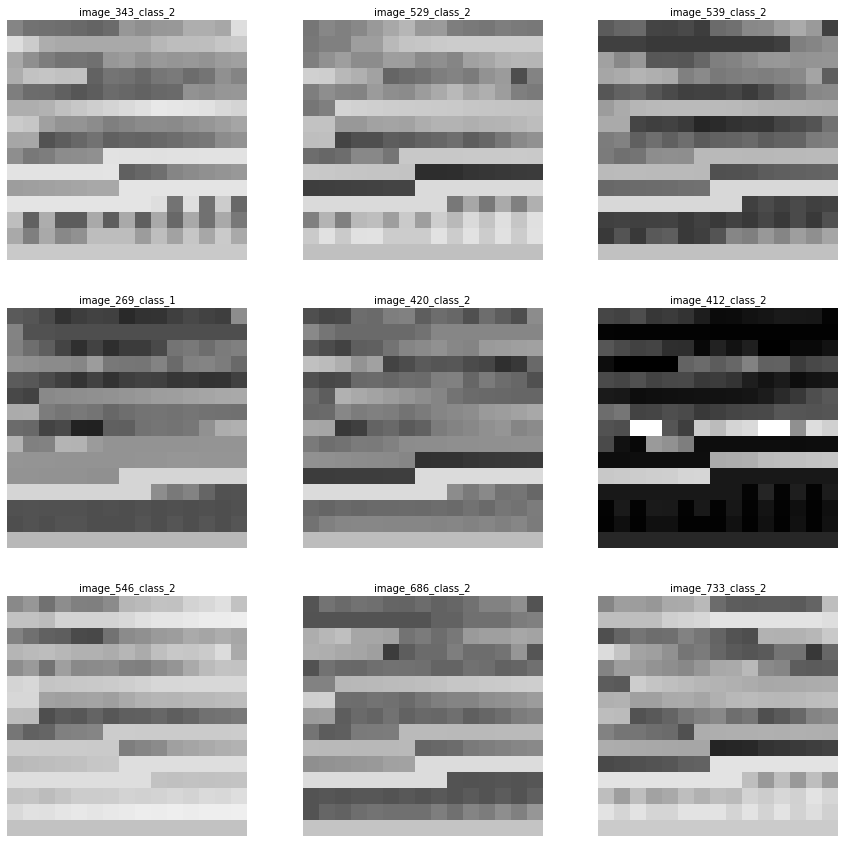

In [25]:
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15, 15))
columns = rows = 3
for i in range(1, columns*rows +1):
    index = np.random.randint(len(x_train))
    img = x_train[index]
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.title('image_'+str(index)+'_class_'+str(np.argmax(y_train[index])), fontsize=10)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.imshow(img)
plt.show()

In [0]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import RandomUniform, RandomNormal
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

params = {'batch_size': 80, 'conv2d_layers': {'conv2d_do_1': 0.22, 'conv2d_filters_1': 35, 'conv2d_kernel_size_1': 2, 'conv2d_mp_1': 2, 
                                              'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 'conv2d_do_2': 0.05, 
                                              'conv2d_filters_2': 20, 'conv2d_kernel_size_2': 2, 'conv2d_mp_2': 2, 'conv2d_strides_2': 2, 
                                              'kernel_regularizer_2': 0.0, 'layers': 'two'}, 
          'dense_layers': {'dense_do_1': 0.22, 'dense_nodes_1': 100, 'kernel_regularizer_1': 0.0, 'layers': 'one'},
          'epochs': 3000, 'lr': 0.001, 'optimizer': 'adam'}

# Original paper CNN params: input layer (15x15), two convolutional layers (15x15x32, 15x15x64),
# a max pooling (7x7x64), two dropout (0.25, 0.50), fully connected layers (128), and an out-
# put layer (3). stride?
# params = {'batch_size': 80, 'conv2d_layers': {'conv2d_do_1': 0.25, 'conv2d_filters_1': 32, 'conv2d_kernel_size_1': 3, 'conv2d_mp_1': 0, 
#                                                'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 'conv2d_do_2': 0.5, 
#                                                'conv2d_filters_2': 64, 'conv2d_kernel_size_2': 3, 'conv2d_mp_2': 7, 'conv2d_strides_2': 1, 
#                                                'kernel_regularizer_2': 0.0, 'layers': 'two'}, 
#            'dense_layers': {'dense_do_1': 0.0, 'dense_nodes_1': 128, 'kernel_regularizer_1': 0.0, 'layers': 'one'},
#            'epochs': 3000, 'lr': 0.001, 'optimizer': 'adam'}

In [0]:
from functools import *
from sklearn.metrics import f1_score
from tensorflow.keras.metrics import AUC

def f1_custom(y_true, y_pred):
    y_t = np.argmax(y_true, axis=1)
    y_p = np.argmax(y_pred, axis=1)
    f1_score(y_t, y_p, labels=None, average='weighted', sample_weight=None, zero_division='warn')

def create_model_cnn(params):
    model = Sequential()

    print("Training with params {}".format(params))
    # (batch_size, timesteps, data_dim)
    # x_train, y_train = get_data_cnn(df, df.head(1).iloc[0]["timestamp"])[0:2]
    conv2d_layer1 = Conv2D(params["conv2d_layers"]["conv2d_filters_1"],
                           params["conv2d_layers"]["conv2d_kernel_size_1"],
                           strides=params["conv2d_layers"]["conv2d_strides_1"],
                           kernel_regularizer=regularizers.l2(params["conv2d_layers"]["kernel_regularizer_1"]), 
                           padding='valid',activation="relu", use_bias=True,
                           kernel_initializer='glorot_uniform',
                           input_shape=(x_train[0].shape[0],
                                        x_train[0].shape[1], x_train[0].shape[2]))
    model.add(conv2d_layer1)
    if params["conv2d_layers"]['conv2d_mp_1'] == 1:
        model.add(MaxPool2D(pool_size=2))
    model.add(Dropout(params['conv2d_layers']['conv2d_do_1']))
    if params["conv2d_layers"]['layers'] == 'two':
        conv2d_layer2 = Conv2D(params["conv2d_layers"]["conv2d_filters_2"],
                               params["conv2d_layers"]["conv2d_kernel_size_2"],
                               strides=params["conv2d_layers"]["conv2d_strides_2"],
                               kernel_regularizer=regularizers.l2(params["conv2d_layers"]["kernel_regularizer_2"]),
                               padding='valid',activation="relu", use_bias=True,
                               kernel_initializer='glorot_uniform')
        model.add(conv2d_layer2)
        if params["conv2d_layers"]['conv2d_mp_2'] == 1:
            model.add(MaxPool2D(pool_size=2))
        model.add(Dropout(params['conv2d_layers']['conv2d_do_2']))

    model.add(Flatten())

    model.add(Dense(params['dense_layers']["dense_nodes_1"], activation='relu'))
    model.add(Dropout(params['dense_layers']['dense_do_1']))

    if params['dense_layers']["layers"] == 'two':
        model.add(Dense(params['dense_layers']["dense_nodes_2"], activation='relu', 
                        kernel_regularizer=params['dense_layers']["kernel_regularizer_1"]))
        model.add(Dropout(params['dense_layers']['dense_do_2']))

    model.add(Dense(3, activation='softmax'))
    if params["optimizer"] == 'rmsprop':
        optimizer = optimizers.RMSprop(lr=params["lr"])
    elif params["optimizer"] == 'sgd':
        optimizer = optimizers.SGD(lr=params["lr"], decay=1e-6, momentum=0.9, nesterov=True)
    elif params["optimizer"] == 'adam':
        optimizer = optimizers.Adam(learning_rate=params["lr"], beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_metric])
    # from keras.utils.vis_utils import plot_model use this too for diagram with plot
    # model.summary(print_fn=lambda x: print(x + '\n'))
    return model

def check_baseline(pred, y_test):
    print("size of test set", len(y_test))
    e = np.equal(pred, y_test)
    print("TP class counts", np.unique(y_test[e], return_counts=True))
    print("True class counts", np.unique(y_test, return_counts=True))
    print("Pred class counts", np.unique(pred, return_counts=True))
    holds = np.unique(y_test, return_counts=True)[1][2]  # number 'hold' predictions
    print("baseline acc:", (holds/len(y_test)*100))

Training with params {'batch_size': 80, 'conv2d_layers': {'conv2d_do_1': 0.22, 'conv2d_filters_1': 35, 'conv2d_kernel_size_1': 2, 'conv2d_mp_1': 2, 'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 'conv2d_do_2': 0.05, 'conv2d_filters_2': 20, 'conv2d_kernel_size_2': 2, 'conv2d_mp_2': 2, 'conv2d_strides_2': 2, 'kernel_regularizer_2': 0.0, 'layers': 'two'}, 'dense_layers': {'dense_do_1': 0.22, 'dense_nodes_1': 100, 'kernel_regularizer_1': 0.0, 'layers': 'one'}, 'epochs': 3000, 'lr': 0.001, 'optimizer': 'adam'}
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


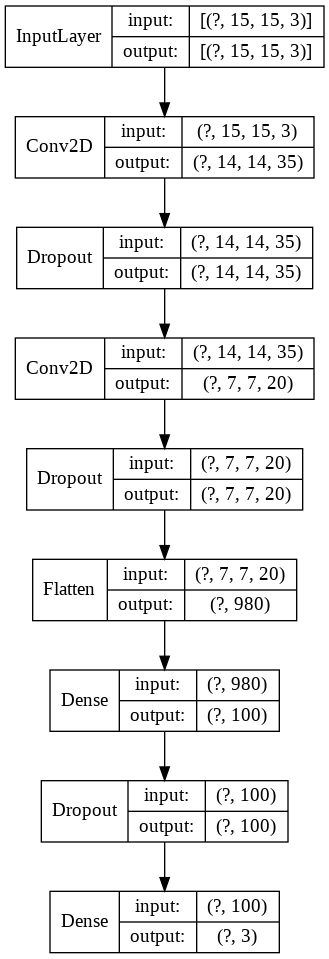

In [28]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

model = create_model_cnn(params)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
import os

best_model_path = os.path.join('/content/drive/My Drive/Colab Notebooks/cnn output/', 'best_model_keras/bestModel.h5')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                   patience=100, min_delta=0.0001)
# csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'log_training_batch.log'), append=True)
rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.02, patience=20, verbose=1, mode='min',
                        min_delta=0.001, cooldown=1, min_lr=0.0001)
mcp = ModelCheckpoint(best_model_path, monitor='f1_metric', verbose=1,
                      save_best_only=True, save_weights_only=False, mode='max', save_freq=1)  # val_f1_metric

In [30]:
sample_weights.shape

(782,)

In [31]:
# %%time
from keras.utils import to_categorical
# history = model.compile(sample_weight_mode="temporal", loss ="sparse_categorical_crossentropy")
history = model.fit(x_train, y_train, epochs=params['epochs'], verbose=1,
                            batch_size=64, shuffle=True,
                            # validation_split=0.3,
                            validation_data=(x_cv, y_cv),
                            callbacks=[mcp, rlp, es],
                            sample_weight=sample_weights)

Using TensorFlow backend.


Train on 782 samples, validate on 196 samples
Epoch 1/3000

Epoch 00001: f1_metric improved from -inf to 0.00000, saving model to /content/drive/My Drive/Colab Notebooks/cnn output/best_model_keras/bestModel.h5
 64/782 [=>............................] - ETA: 3s - loss: 1.0413 - acc: 0.1562 - f1_metric: 0.0000e+00
Epoch 00001: f1_metric did not improve from 0.00000

Epoch 00001: f1_metric did not improve from 0.00000

Epoch 00001: f1_metric did not improve from 0.00000
256/782 [========>.....................] - ETA: 0s - loss: 1.0710 - acc: 0.3086 - f1_metric: 0.0000e+00
Epoch 00001: f1_metric did not improve from 0.00000

Epoch 00001: f1_metric did not improve from 0.00000

Epoch 00001: f1_metric did not improve from 0.00000
448/782 [================>.............] - ETA: 0s - loss: 1.0998 - acc: 0.3549 - f1_metric: 0.0000e+00
Epoch 00001: f1_metric did not improve from 0.00000

Epoch 00001: f1_metric did not improve from 0.00000

Epoch 00001: f1_metric did not improve from 0.00000
640

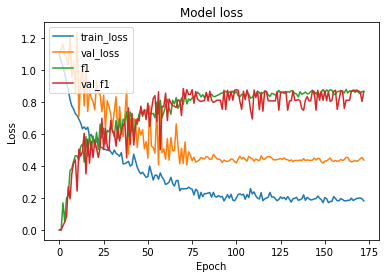

In [32]:
from matplotlib import pyplot as plt
%matplotlib inline
InteractiveShell.ast_node_interactivity = "last"

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['f1_metric'])
plt.plot(history.history['val_f1_metric'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss', 'f1', 'val_f1'], loc='upper left')
plt.show()

In [36]:
from sklearn.metrics import confusion_matrix, roc_auc_score, cohen_kappa_score
import seaborn as sns

model = load_model(best_model_path)
test_res = model.evaluate(x_test, y_test, verbose=0)
print("keras evaluate=", test_res)
pred = model.predict(x_test)
pred_classes = np.argmax(pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
check_baseline(pred_classes, y_test_classes)
conf_mat = confusion_matrix(y_test_classes, pred_classes)
print(conf_mat)
labels = [0,1,2]
# ax = sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)
# ax.xaxis.set_ticks_position('top')
f1_weighted = f1_score(y_test_classes, pred_classes, labels=None, 
         average='weighted', sample_weight=None)
print("F1 score (weighted)", f1_weighted)
print("F1 score (macro)", f1_score(y_test_classes, pred_classes, labels=None, 
         average='macro', sample_weight=None))
print("F1 score (micro)", f1_score(y_test_classes, pred_classes, labels=None, 
         average='micro', sample_weight=None))  # weighted and micro preferred in case of imbalance
# https://scikit-learn.org/stable/modules/model_evaluation.html#cohen-s-kappa --> supports multiclass; ref: https://stats.stackexchange.com/questions/82162/cohens-kappa-in-plain-english
print("cohen's Kappa", cohen_kappa_score(y_test_classes, pred_classes))

prec = []
for i, row in enumerate(conf_mat):
    prec.append(np.round(row[i]/np.sum(row), 2))
    print("precision of class {} = {}".format(i, prec[i]))
print("precision avg", sum(prec)/len(prec))


accuracy = accuracy_score(y_test_classes, pred_classes)
print("Accuracy score:", accuracy)

keras evaluate= [0.4129285111719248, 0.8122449, 0.8121279]
size of test set 245
TP class counts (array([0, 1, 2]), array([ 11,   9, 179]))
True class counts (array([0, 1, 2]), array([ 14,  14, 217]))
Pred class counts (array([0, 1, 2]), array([ 35,  23, 187]))
baseline acc: 88.57142857142857
[[ 11   0   3]
 [  0   9   5]
 [ 24  14 179]]
F1 score (weighted) 0.8383208338956976
F1 score (macro) 0.6072015640615357
F1 score (micro) 0.8122448979591836
cohen's Kappa 0.3951915852742298
precision of class 0 = 0.79
precision of class 1 = 0.64
precision of class 2 = 0.82
precision avg 0.75
Accuracy score: 0.8122448979591836


In [34]:
x_test_copy['Predictions'] = y_test_classes

x_test_copy[['Predictions']]
count = 0
for index, row in x_test_copy.iterrows():
  if row['Predictions'] != 2:
    if row['Predictions'] == 1: #buying
      price = df.iloc[index]
      now_price = price['close']
      day7_price = df.iloc[index + 7]
      day7_price = day7_price['close']
      profit = day7_price - now_price
      count += profit
    
    else:
      price = df.iloc[index]
      now_price = price['close']
      day7_price = df.iloc[index + 7]
      day7_price = day7_price['close']
      profit = now_price - day7_price
      count += profit

print("Profits", count)

Profits -2238.270996000002
